# LMU Network Modelling psMNIST

In [3]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf

from lmu import LMUCell

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical

ModuleNotFoundError: No module named 'tensorflow'

# Step 1: Loading and Formatting the Dataset

In [ ]:
# Set seed to ensure this example is reproducible
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

# load mnist dataset
(
    (train_images, train_labels),
    (test_images, test_labels),
) = tf.keras.datasets.mnist.load_data()

# Change inputs to 0--1 range
train_images = train_images / 255
test_images = test_images / 255

# Flatten images into sequences
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# Apply permutation
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

X_train = train_images[0:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[0:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

# Step 2: Displaying a Training Example

In [ ]:
plt.subplot(111)
plt.title("Digit = %d" % Y_train[1])
plt.imshow(X_train[1].reshape(28, 28))
plt.colorbar()
plt.show()

# Step 3: Defining the Model

In [4]:
padded_length = 28 ** 2 + 1
n_pixels = padded_length - 1


def lmu_layer(**kwargs):
    return RNN(
        # For a more detailed understanding of these
        # parameters, we recommend reading this
        # technical overview, 
        # http://compneuro.uwaterloo.ca/files/publications/voelker.2019.lmu.pdf
        LMUCell(
            units=212,
            order=256,
            theta=n_pixels,
            input_encoders_initializer=Constant(1),
            hidden_encoders_initializer=Constant(0),
            memory_encoders_initializer=Constant(0),
            input_kernel_initializer=Constant(0),
            hidden_kernel_initializer=Constant(0),
            memory_kernel_initializer="glorot_normal",
        ),
        return_sequences=False,
        **kwargs
    )


# Adding LMU and Dense layer to Sequential model
model = Sequential()
model.add(lmu_layer(input_shape=X_train.shape[1:],))  # (nr. of pixels, 1)
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

NameError: name 'Sequential' is not defined

# Step 4: Training the Model

In [2]:
do_training = False
batch_size = 100
epochs = 10
t = time.time()

fname = "./psMNIST-standard.hdf5"
callbacks = [
    ModelCheckpoint(filepath=fname, monitor="val_loss", verbose=1, save_best_only=True),
]

# Training generally takes a long time to
# execute, and for the purpose of this
# example, pretrained weights will be
# applied.
if do_training:
    
    result = model.fit(
        X_train,
        to_categorical(Y_train),
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, to_categorical(Y_valid)),
        callbacks=callbacks,
    )

    print("Took {:.2f} min".format((time.time() - t) / 60))

NameError: name 'time' is not defined

# Step 5: Plotting Learning

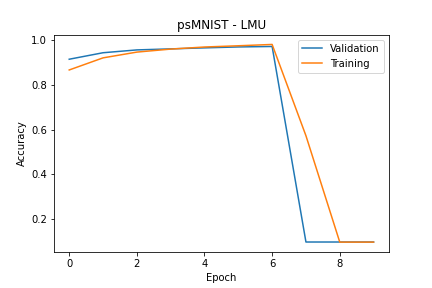

In [30]:
if do_training:
    
    plt.figure()
    plt.plot(result.history["val_accuracy"], label="Validation")
    plt.plot(result.history["accuracy"], label="Training")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("psMNIST - LMU")
    plt.savefig("psMNIST-LMU Learning.png")

else:

    display(Image(filename='psMNIST-LMU Learning.png'))

# Step 6: Saving the Trained Weights

In [31]:
if do_training:
    
    # Saves weights to file, fname
    saved_epoch = np.argmin(result.history["val_loss"])
    print(result.history["val_accuracy"][saved_epoch])

# Step 7: Loading the Trained/Saved Weights

In [32]:
model.load_weights(fname)  # load best weights

# Step 8: Testing the Model

In [9]:
model.evaluate(X_test, to_categorical(Y_test))

313/313 [==============================] - 43s 138ms/step - loss: 0.1052 - accuracy: 0.9683


[0.10522755235433578, 0.9682999849319458]